In [2]:
import spacy 
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

from os import walk, system, path
import re

from matplotlib import colors
%matplotlib inline

In [3]:
css_colors = list(colors.CSS4_COLORS.keys())
css_colors = pd.Series(css_colors)
css_hsv = (css_colors
    .apply(colors.to_rgb)
    .apply(colors.rgb_to_hsv)
    .apply(pd.Series)
)
css_hsv['name'] = css_colors
css_hsv = css_hsv[css_hsv[1] > 0.3]
css_hsv = css_hsv.reset_index()

# map_color = { i:color for i, color in enumerate(css_colors)}
map_color = css_hsv.name
map_color

0            aqua
1      aquamarine
2            blue
3      blueviolet
4           brown
         ...     
88         tomato
89      turquoise
90         violet
91         yellow
92    yellowgreen
Name: name, Length: 93, dtype: object

## Read corpus files

In [4]:
corpus_path = '../Files/project_corpus/'
file_texts = []
for (dirpath, dirnames, filenames) in walk(corpus_path):
  files = [ path.join(dirpath, filename) for filename in filenames if filename[-3:] == 'txt']
  for file_name in files:
    with open(file_name, 'r') as file:
        file_texts.append(file.read())
file_texts = pd.Series(file_texts)
file_texts

0     Treatment of 5 Critically Ill Patients With CO...
1     The use of anti-inflammatory drugs in the trea...
2     ﻿Trypsin Treatment Unlocks Barrier for Zoonoti...
3     ﻿The epidemic of 2019-novel-coronavirus (2019-...
4     ﻿The origin, transmission and clinical therapi...
5     Transcriptomic characteristics of bronchoalveo...
6     Viral etiologies of acute respiratory tract in...
7     Complementary Therapies in Clinical Practice 3...
8     ﻿International Journal of Biological Sciences\...
9     ﻿Construction and application of carbohydrate ...
10    ﻿\nstatistical analysis plan for a recursive t...
11    ﻿Therapeutic strategies in an outbreak scenari...
12    ﻿Clinical trials on drug repositioning for COV...
13    The immune response of young turkeys to haemor...
14    ﻿The epidemiology and pathogenesis of coronavi...
dtype: object

## Load spacy large model

In [5]:
nlp_model = spacy.load('en_core_web_lg')
nlp_model

## Process each document

In [6]:
file_texts = file_texts.apply(nlp_model)
file_texts

0     (Treatment, of, 5, Critically, Ill, Patients, ...
1     (The, use, of, anti, -, inflammatory, drugs, i...
2     (﻿Trypsin, Treatment, Unlocks, Barrier, for, Z...
3     (﻿The, epidemic, of, 2019-novel, -, coronaviru...
4     (﻿The, origin, ,, transmission, and, clinical,...
5     (Transcriptomic, characteristics, of, bronchoa...
6     (Viral, etiologies, of, acute, respiratory, tr...
7     (Complementary, Therapies, in, Clinical, Pract...
8     (﻿International, Journal, of, Biological, Scie...
9     (﻿Construction, and, application, of, carbohyd...
10    (﻿, \n, statistical, analysis, plan, for, a, r...
11    (﻿Therapeutic, strategies, in, an, outbreak, s...
12    (﻿Clinical, trials, on, drug, repositioning, f...
13    (The, immune, response, of, young, turkeys, to...
14    (﻿The, epidemiology, and, pathogenesis, of, co...
dtype: object

## Extrract entities for the first document

In [7]:
entities = pd.DataFrame({'entitie': file_texts[0].ents})
entities['has_vector'] = entities.entitie.apply(lambda e: e.has_vector)
with_vector = entities[entities.has_vector == True]
del with_vector['has_vector']
entities[entities.has_vector == False]

,entitie,has_vector
44,"(Yujing, \n)",False
73,(ECMO),False
77,(methylprednisolone),False


## Modelo 1: con el token mas largo

In [8]:
model_1_df = with_vector.copy()

model_1_df['entitie'] = model_1_df.entitie.apply(lambda tokens: [t for t in tokens if not t.is_digit])
model_1_df = model_1_df[model_1_df.entitie.apply(len) != 0]
model_1_df['lenghts'] = model_1_df.entitie.apply(lambda tokens: [len(t) for t in tokens])
model_1_df['longest'] = model_1_df.lenghts.apply(np.argmax)

model_1_df['final entitie'] = model_1_df[['entitie', 'longest']].apply(lambda row: row['entitie'][row['longest']], axis=1)
model_1_df['vector'] = model_1_df['final entitie'].apply(lambda e: e.vector)
model_1_df

,entitie,lenghts,longest,final entitie,vector
0,"[Chenguang, Shen]","[9, 4]",0,Chenguang,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,[PhD],[3],0,PhD,"[-0.32823, 0.21099, 0.1571, 0.10158, 0.26148, ..."
2,"[Zhaoqin, Wang]","[7, 4]",0,Zhaoqin,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,[PhD],[3],0,PhD,"[-0.32823, 0.21099, 0.1571, 0.10158, 0.26148, ..."
4,"[Fang, Zhao]","[4, 4]",0,Fang,"[0.30761, -0.062862, 0.3755, -0.61801, 0.22023..."
...,...,...,...,...,...
91,[days],[4],0,days,"[0.17757, 0.28917, 0.095572, -0.47787, -0.1418..."
93,[weeks],[5],0,weeks,"[0.016085, 0.25982, -0.023239, 0.093751, -0.32..."
98,[days],[4],0,days,"[0.17757, 0.28917, 0.095572, -0.47787, -0.1418..."
100,[days],[4],0,days,"[0.17757, 0.28917, 0.095572, -0.47787, -0.1418..."


#### Transform the dataset to use clustering

In [9]:
vector_df = model_1_df.vector.apply(pd.Series)
vector_df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,-0.328230,0.210990,0.157100,0.101580,0.26148,0.16176,0.037014,-0.132930,0.075937,-0.006255,...,0.950630,-0.10052,0.353920,0.066575,0.408110,-0.26122,0.114590,0.249960,-0.541760,0.088163
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
3,-0.328230,0.210990,0.157100,0.101580,0.26148,0.16176,0.037014,-0.132930,0.075937,-0.006255,...,0.950630,-0.10052,0.353920,0.066575,0.408110,-0.26122,0.114590,0.249960,-0.541760,0.088163
4,0.307610,-0.062862,0.375500,-0.618010,0.22023,-0.22466,0.489520,0.076042,-0.148970,-0.703680,...,0.048828,0.13024,-0.627850,-0.340130,0.099402,0.13377,-0.049766,-0.033670,0.367840,-0.026209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.177570,0.289170,0.095572,-0.477870,-0.14183,-0.39989,-0.519440,-0.346780,0.465470,2.381400,...,0.151210,0.15204,0.083258,-0.095562,0.007544,-0.18193,-0.074212,0.210400,0.006014,-0.121580
93,0.016085,0.259820,-0.023239,0.093751,-0.32154,-0.70932,-0.284650,-0.373070,0.514660,2.399300,...,0.224430,-0.16763,0.164950,0.108990,0.071225,-0.25524,0.075524,0.083691,-0.084957,-0.199660
98,0.177570,0.289170,0.095572,-0.477870,-0.14183,-0.39989,-0.519440,-0.346780,0.465470,2.381400,...,0.151210,0.15204,0.083258,-0.095562,0.007544,-0.18193,-0.074212,0.210400,0.006014,-0.121580
100,0.177570,0.289170,0.095572,-0.477870,-0.14183,-0.39989,-0.519440,-0.346780,0.465470,2.381400,...,0.151210,0.15204,0.083258,-0.095562,0.007544,-0.18193,-0.074212,0.210400,0.006014,-0.121580


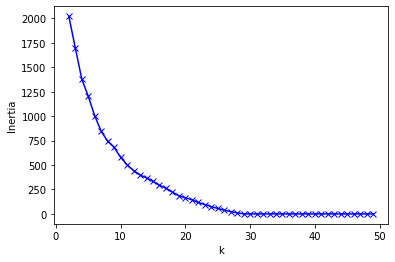

In [10]:
Sum_of_squared_distances = []
K = range(2,50)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(vector_df.to_numpy())
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

## Modelo 2: bag of chars
Extraer todos los grupos de caracteres del archivo y representarlos como un componente del vector de reprersentacion.
* Un grupo parar cada letra del alfabeto en inglés sensible a mayusculas. (52)
* Un grupo que aglomere todos los caracteres especiales menos puntuación (1)
* Un grupo diferrente para comas, puntos, dos puntos, apostrofe y punto y coma (4)
* Un grupo los diferentes digitos (10)
* Un grupo los caracterres de espacio (1)

In [11]:
model_2_df = entities.copy()
del model_2_df['has_vector']

model_2_df['text'] = model_2_df.entitie.apply(lambda e: e.text)
full_text = ' '.join(model_2_df.text)


In [12]:
alphanum_re = re.compile(r'[A-Za-z0-9]')
punct_re = re.compile(r'[\.,:;\'\"]')
blank_re = re.compile(r'\s+')
special_re = re.compile(r'[^A-Za-z0-9\s\.,:;\'"]')

# def bag_of_chars(text):
    
#     for a in text:

test = "sfsdfasdfsd@@¢#@.\t\t\t 342343 dfsdgfd ñæ∂∫©€ ardillasaurio,...'''\"\"\""
blank_re.findall(test)

['\t\t\t ', ' ', ' ', ' ']

In [13]:
model_2_df = with_vector.copy()
model_2_df['text'] = model_2_df.entitie.apply(lambda e: e.text)
chars_df =

SyntaxError: invalid syntax (<ipython-input-13-1af4a40d7099>, line 3)